In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio
from scipy.io import FortranFile

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Writer will output to ./runs/ directory by default

In [11]:
f = FortranFile('C:/Users/Lawrence Huang/Desktop/Research/z3taured.dat', 'r')
nlos=int(np.asscalar(f.read_ints()))
print("nlos = %d" %nlos)
npix=int(np.asscalar(f.read_ints()))
zred=np.asscalar(f.read_record('f4'))
blenkms=np.asscalar(f.read_record('f4'))
blen=np.asscalar(f.read_record('f4'))*0.001  #back into mpc/h
print(nlos,npix,zred,blenkms,blen)
taured=[]
nstep=128 #skipping through in steps of 64
for i in range(0,nlos,nstep):       
    tauredin=f.read_record('f4')
    taured.extend(tauredin)
f.close()
print('len(taured)=',len(taured))

nlos=int(nlos/nstep)

print ('nlos,npix=',nlos,npix)

taured=np.array(taured)

taured=np.reshape(taured,(nlos,npix))

print('shape of taured=',taured.shape)

print(taured[0,0],taured[0,1])


nlos = 65536
65536 512 3.0 42807.71484375 400.0
len(taured)= 262144
nlos,npix= 512 512
shape of taured= (512, 512)
13.272697 13.76669


15.892097


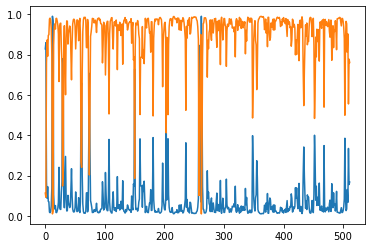

In [12]:
mintaured=taured.min()
maxtaured=taured.max()
taured[taured > 0.5e9] = -1.e10

maxtaured=taured.max()
print (maxtaured)
# set to realistic max:

taured[taured < -0.5e9] = maxtaured
taured=(((taured-mintaured)/(maxtaured-mintaured))*0.98)+0.01
flux=np.exp(-1.*taured)
rmsnoise=0.0 #this is the rms noise to add - if it's zero then we are try 
noise = np.random.normal(0.0,rmsnoise,(nlos,npix))
# 1 is the mean of the normal distribution you are choosing from
# 2 is the standard deviation of the normal distribution
# 3 is the number of elements you get in array noise
flux=flux+noise
minflux=flux.min()
maxflux=flux.max()
flux=(((flux-minflux)/(maxflux-minflux))*0.98)+0.01
taured = torch.from_numpy(taured)
flux = torch.from_numpy(flux)
tauredzero=taured[0,...]

fluxzero=flux[0,...]

#orange is the flux and blue is the optical depth, both scaled to 0.01-0.99
plt.plot(tauredzero.numpy())
plt.plot(fluxzero.numpy())

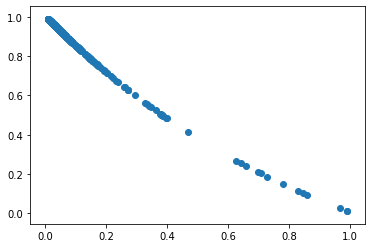

In [4]:
plt.scatter(tauredzero,fluxzero)

In [5]:
a = torch.linspace(0,1,100)
b = torch.tensor([0,10,20,30,40,50,60,70,80,90])

In [6]:
tauredTest = taured[480:,...]
fluxTest = flux[480:,...]
tauredTrain = taured[:480,...]
fluxTrain = flux[:480,...]
print(tauredTest.shape)
print(fluxTest.shape)
print(tauredTrain.shape)
print(fluxTrain.shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([480, 512])
torch.Size([480, 512])


SHAPE
torch.Size([48, 512])


RuntimeError: Expected 3-dimensional input for 3-dimensional weight 3 1 5, but got 2-dimensional input of size [48, 512] instead

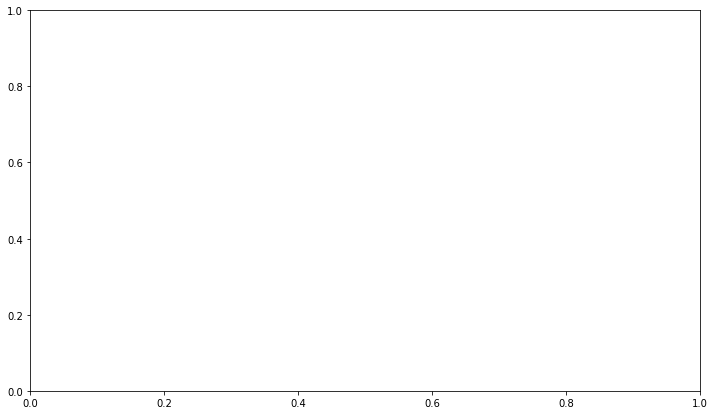

In [13]:

writer = SummaryWriter()

def trainSplit(tauredSet, fluxSet, num):
    indices = torch.randint(low=0,high=tauredSet.shape[0],size=(num,))
#     print(indices)
#     print(tauredSet[indices,...])
#     print(fluxSet[indices,...])
    print("SHAPE")
    print(tauredSet[indices,...].shape)
    return tauredSet[indices,256], fluxSet[indices,...]
    

#to test
def validate():
    loss = np.zeros(32)
    net.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(32):
            y = fluxTest[i,...].float()
            y = torch.reshape(y, (-1,1,512))
            prediction = net(y)
            loss[i] = loss_func(prediction, tauredTest[i,256].float())
        # print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))
    net.train()
    return np.mean(loss)



# this is one way to define a network
class OnePointConvNet(torch.nn.Module):
    def __init__(self):
        super(OnePointConvNet, self).__init__()
        self.hidden1 = torch.nn.Conv1d(1, 3, 5)   # hidden layer
        self.pool1 = torch.nn.MaxPool1d(5,stride = 1)
        self.hidden2 = torch.nn.Linear(504,1000)
        self.hidden3 = torch.nn.Linear(1000, 2000)
        self.hidden4 = torch.nn.Linear(2000, 2500)
        self.hidden5 = torch.nn.Linear(2500,3200)
        self.hidden6 = torch.nn.Linear(3200,4800)
        self.hidden7 = torch.nn.Conv1d(3,1,11)
        self.predict = torch.nn.Linear(4790, 1)   # output layer

    def forward(self, x):
#         IT IS NOT AN ISSUE WITH PASSING THE INFORMATION IN
#         plt.figure()
#         plt.plot(x.reshape(-1).detach())
#         plt.show()
        x = F.relu(self.hidden1(x))
        x = self.pool1(x)
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = F.relu(self.hidden6(x))
        x = F.relu(self.hidden7(x))
        x = self.predict(x)
        return x

# net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
epochs = 5
learningRate = 0.0002
net = OnePointConvNet()

writer.add_text("Net", str(net))
writer.add_text("Epochs", str(epochs))
writer.add_text("Learning Rate", str(learningRate))


# print(net)  # net architecture
# optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
optimizer = torch.optim.Adam( net.parameters(), learningRate, weight_decay=0.0005 )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.3)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss
my_images = []
fig, ax = plt.subplots(figsize=(12,7))
totalTrainLoss = torch.zeros(epochs)
totalTestLoss = torch.zeros(epochs)
predictedMean = torch.zeros(epochs)
tauredMean = torch.zeros(epochs)
a = torch.zeros(512)
a = torch.reshape(a, (-1,1,512))
# train the network
for t in range(epochs):
    
    x,y = trainSplit(tauredTrain, fluxTrain, 48)
    x = x.float()
    y = y.float()
#     print(x.shape)
#     print(y.shape)
    x = torch.reshape(x, (-1,1,1))
    y = torch.reshape(y, (-1,1,512))
    prediction = net(y)     # input x and predict based on x
    print("Prediction: ", prediction.shape)
    if torch.equal(prediction[1], prediction[2]) and torch.equal(prediction[2], prediction[37]):
        print("They're all the same")
        print("They're all", prediction[1])
    loss = loss_func(prediction, x)     # must be (1. nn output, 2. target)
    

    
    
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    scheduler.step()        # scheduler decreases learning rate geometrically every n epochs
    

    
    testLoss = validate()
    totalTrainLoss[t] = loss
    totalTestLoss[t] = testLoss
    
    
    writer.add_scalar('Loss/train', loss, t)
    writer.add_scalar('Loss/test', testLoss, t)
    writer.add_histogram('Hidden1/weight', net.hidden1.weight.grad, t)
    writer.add_histogram('Hidden1/bias', net.hidden1.bias.grad, t)
    writer.add_histogram('Hidden2/weight', net.hidden2.weight.grad, t)
    writer.add_histogram('Hidden2/bias', net.hidden2.bias.grad, t)
    writer.add_histogram('Hidden3/weight', net.hidden3.weight.grad, t)
    writer.add_histogram('Hidden3/bias', net.hidden3.bias.grad, t)
    writer.add_histogram('Hidden4/weight', net.hidden4.weight.grad, t)
    writer.add_histogram('Hidden4/bias', net.hidden4.bias.grad, t)
    writer.add_histogram('Hidden5/weight', net.hidden5.weight.grad, t)
    writer.add_histogram('Hidden5/bias', net.hidden5.bias.grad, t)
    writer.add_histogram('Hidden6/weight', net.hidden6.weight.grad, t)
    writer.add_histogram('Hidden6/bias', net.hidden6.bias.grad, t)
    writer.add_histogram('Hidden7/weight', net.hidden7.weight.grad, t)
    writer.add_histogram('Hidden7/bias', net.hidden7.bias.grad, t)
    writer.add_histogram('Predict/weight', net.predict.weight.grad, t)
    writer.add_histogram('Predict/bias', net.predict.bias.grad, t)
#     predictedMean[t] = prediction.mean()
#     tauredMean[t] = x.mean()
    
    print("Epoch = ", t)
    print("Training Loss = ", loss)
    print("Test Loss = ", testLoss)
#     print(x.shape)
#     for k in range(48):
# #         print(x.shape)
#         s = torch.reshape(x[k], (-1,))
#         r = torch.reshape(prediction[k], (-1,))
#     # plot and show learning process
#         plt.cla()
#         ax.set_title('Regression Analysis', fontsize=35)
#         ax.set_xlabel('', fontsize=24)
#         ax.set_ylabel('Tau', fontsize=24)
#         ax.plot(s.data.cpu().numpy(), "r.")
#         ax.plot(r.data.cpu().numpy(), 'g.', lw=3)
#         ax.text(0.6, 0.8, 'Step = %d' % t, fontdict={'size': 24, 'color':  'red'})
#         ax.text(0.6, 0.7, 'Loss = %.4f' % loss.data.cpu().numpy(),
#                 fontdict={'size': 24, 'color':  'red'})

# #         ax.set_xlim(0,1.0)
#         ax.set_ylim(0,1.1)

#         # Used to return the plot as an image array 
#         # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
#         fig.canvas.draw()       # draw the canvas, cache the renderer
#         image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#         image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#     my_images.append(image)
    
   


# save images as a gif    
# imageio.mimsave('./taured_prediction.gif', my_images, fps=10)

a = x.view((48,1))
b = y.view((48,512))
c = prediction.view((48,1))
testResults =plt.figure()
plt.plot(a.data.cpu().numpy(), "r", label="actual")
plt.title("prediction vs actual value")
plt.plot(c.data.cpu().numpy(), "g", label="prediction")
expPred = -np.log(b.data.cpu().numpy())
newExpPred = expPred[...,256]
plt.plot(newExpPred, 'b', label="exp")
plt.ylabel("Tau")
plt.xlabel("Sample #")
plt.legend()
plt.show()
newLoss = np.sqrt((a[1].cpu().numpy()-newExpPred)**2).mean()
oldLoss = np.sqrt((a[1].cpu().numpy()-c.detach().cpu().numpy())**2).mean()
print("Exponential Regression Loss = ", newLoss)
print("Prediction Loss = ", oldLoss)
# print(expPred)
# print(prediction)
plt.figure()
plt.title("Loss")
plt.plot(totalTrainLoss.detach().cpu().numpy(), label="Training Loss")
plt.plot(totalTestLoss.detach().cpu().numpy(), label="Test Loss")
plt.legend()
plt.show()

print(totalTrainLoss.shape)
print(totalTestLoss.shape)

writer.add_figure("Test Results", testResults)


# plt.figure()
# plt.plot(predictedMean.detach())
# plt.plot(tauredMean.detach())
# plt.show()



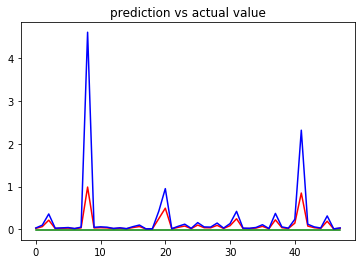

Exponential Regression Loss =  0.22437562
Prediction Loss =  0.07638705


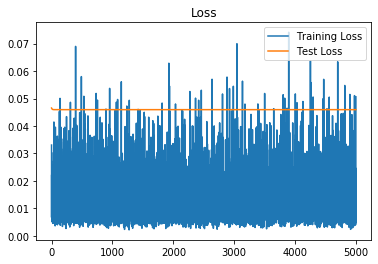

torch.Size([5000])
torch.Size([5000])


In [8]:
#compare to exponential regression
a = x.view((48,1))
b = y.view((48,512))
c = prediction.view((48,1))
plt.figure()
plt.plot(a.data.cpu().numpy(), "r", label="actual")
plt.title("prediction vs actual value")
plt.plot(c.data.cpu().numpy(), "g", label="prediction")
expPred = -np.log(b.data.cpu().numpy())
newExpPred = expPred[...,256]
plt.plot(newExpPred, 'b', label="exp")
plt.show()
newLoss = np.sqrt((a[1].cpu().numpy()-newExpPred)**2).mean()
oldLoss = np.sqrt((a[1].cpu().numpy()-c.detach().cpu().numpy())**2).mean()
print("Exponential Regression Loss = ", newLoss)
print("Prediction Loss = ", oldLoss)
# print(expPred)
# print(prediction)
testResults = plt.figure()
plt.title("Loss")
plt.plot(totalTrainLoss.detach().cpu().numpy(), label="Training Loss")
plt.plot(totalTestLoss.detach().cpu().numpy(), label="Test Loss")
plt.legend()
plt.show()

print(totalTrainLoss.shape)
print(totalTestLoss.shape)

writer.add_figure("Test Results", testResults)


# plt.figure()
# plt.plot(predictedMean.detach())
# plt.plot(tauredMean.detach())
# plt.show()


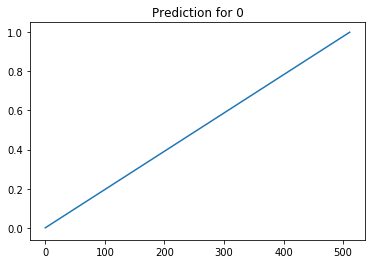

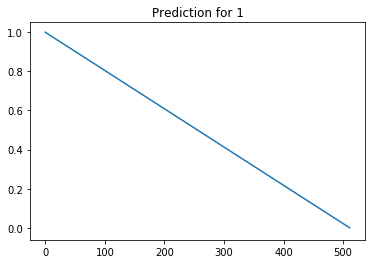

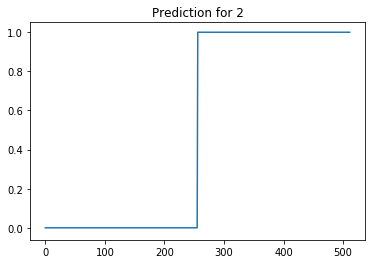

prediction1 equals prediction2:  True
prediction2 equals prediction3:  True
prediction3 equals prediction1:  True
prediction1 - prediction2
tensor([[0.]])
tensor(0.)


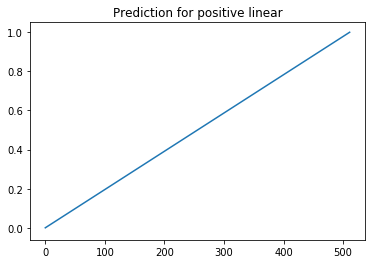

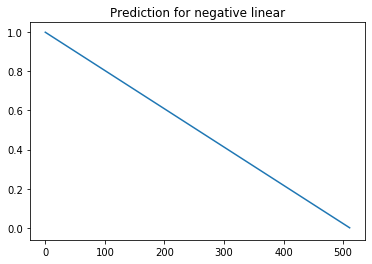

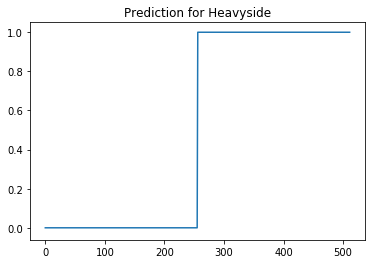

prediction1 equals prediction2:  True
prediction2 equals prediction3:  True
prediction3 equals prediction1:  True
prediction1 - prediction2
tensor([0.])
tensor(0.)


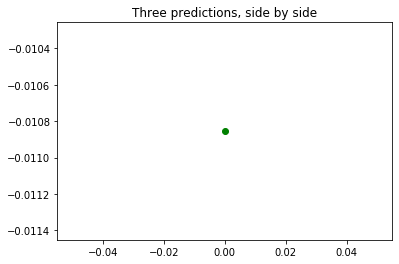

In [9]:
plotY = torch.linspace(0,1,512)
LinearY = torch.reshape(plotY, (-1,1,512))
NegLinearY = 1-1*LinearY
negplotY = 1-1*plotY
heavySidePlot = torch.cat((torch.zeros(256), torch.ones(256)))
HeavySide = torch.reshape(heavySidePlot, (-1,1,512))
net.eval()
with torch.no_grad():
    plots = torch.zeros((3,1,512))
    plots[0,0] = plotY
    plots[1,0] = negplotY
    plots[2,0] = heavySidePlot
    inputs = torch.zeros((3,1,512))
    inputs[0] = LinearY
    inputs[1] = NegLinearY
    inputs[2] = HeavySide
    predictions = net(inputs)
    for j in range(3):
        plot = plots[j]
        forecast = predictions[j]
        plot = plot.reshape(-1)
        forecast = forecast.reshape(-1)
        plt.figure()
        plt.title("Prediction for %d" %j)
        plt.plot(plot.detach().cpu().numpy())
        plt.plot(forecast.detach().cpu().numpy())
        plt.show()
    print("prediction1 equals prediction2: ", torch.equal(prediction[1], prediction[2]))
    print("prediction2 equals prediction3: ", torch.equal(prediction[2], prediction[3]))
    print("prediction3 equals prediction1: ", torch.equal(prediction[3], prediction[1]))
    print("prediction1 - prediction2")
    print(prediction[1]-prediction[2])
    print((((prediction[1]-prediction[2])**2)**.5).mean())

    prediction1 = net(LinearY)
    prediction1 = prediction1.reshape(-1)
    plt.figure()
    plt.title("Prediction for positive linear")
    plt.plot(plotY.detach().cpu().numpy())
    plt.plot(prediction1.detach().cpu().numpy())
    plt.show()

    prediction2 = net(NegLinearY)
    prediction2 = prediction2.reshape(-1)
    plt.figure()
    plt.title("Prediction for negative linear")
    plt.plot(negplotY.detach().cpu().numpy())
    plt.plot(prediction2.detach().cpu().numpy())
    plt.show()

    prediction3 = net(HeavySide)
    prediction3 = prediction3.reshape(-1)
    plt.figure()
    plt.title("Prediction for Heavyside")
    plt.plot(heavySidePlot.detach().cpu().numpy())
    plt.plot(prediction3.detach().cpu().numpy())
    plt.show()
    # print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))
net.train()

print("prediction1 equals prediction2: ", torch.equal(prediction1, prediction2))
print("prediction2 equals prediction3: ", torch.equal(prediction2, prediction3))
print("prediction3 equals prediction1: ", torch.equal(prediction3, prediction1))
print("prediction1 - prediction2")
print(prediction1-prediction2)
print((((prediction1-prediction2)**2)**0.5).mean())

plt.figure()
plt.title("Three predictions, side by side")
plt.plot(prediction1.detach().cpu().numpy(), "r.")
plt.plot(prediction2.detach().cpu().numpy(), "go")
plt.plot(prediction3.detach().cpu().numpy(), "b--")